# Hilo GeoJson Exploration for Yelp API Scrape

In [2]:
#opening libraries
import pandas as pd
import json
import geopandas as gpd


with open('../data/boundaries/hilo.geojson') as f:
    hilo = json.load(f)


fname = '../data/boundaries/hilo.geojson'
hilo_gpd = gpd.read_file(fname)

### Using Shapely LineString

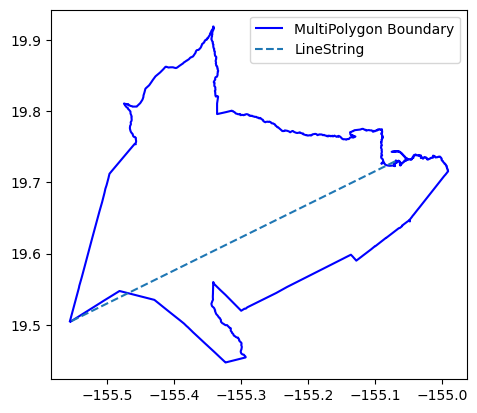

In [2]:
from shapely.geometry import LineString, MultiPolygon
import matplotlib.pyplot as plt
import geopandas as gpd


#### example 


#took random points from file
line_coordinates = [(-155.552627, 19.505175), (-155.0687025, 19.730062)]

#made a line
line = LineString(line_coordinates)

#plot line and shape
fig, ax = plt.subplots()

hilo_gpd['geometry'].boundary.plot(ax=ax, color='blue', label='MultiPolygon Boundary')

x, y = line.xy
ax.plot(x, y, label='LineString', linestyle='dashed')

plt.legend()
plt.show()



We could iterate through x,y points and every n amount of steps we could draw a line so that we get a grid, then we could get each of the intersections of the lines and save them for Yelp.

## trying to make a grid on hilo

In [3]:
import geopandas as gpd

def get_bounding_box(geojson_file):
    # Load GeoJSON file into GeoDataFrame
    gdf = gpd.read_file(geojson_file)

    # Get the total bounding box of all features in the GeoDataFrame
    geojson_bbox = gdf.total_bounds

    # Initialize min_lon, min_lat, max_lon, max_lat using the bounding box of the GeoDataFrame
    min_lon, min_lat, max_lon, max_lat = geojson_bbox

    # Adjust the total bounding box
    total_bbox = (max(min_lon, geojson_bbox[0]), max(min_lat, geojson_bbox[1]),
                  min(max_lon, geojson_bbox[2]), min(max_lat, geojson_bbox[3]))

    return total_bbox


geojson_file = "../data/boundaries/hilo.geojson"
adjusted_bbox = get_bounding_box(geojson_file)

# Print the adjusted bounding box coordinates
min_lon, min_lat, max_lon, max_lat = adjusted_bbox
print(f"Bounding Box: (min_lon={min_lon}, min_lat={min_lat}, max_lon={max_lon}, max_lat={max_lat})")


Bounding Box: (min_lon=-155.555413, min_lat=19.447004, max_lon=-154.990994, max_lat=19.918815)


In [4]:
def generate_quadrants(min_lon, min_lat, max_lon, max_lat, n_lon, n_lat):
    midpoints = []
    quadrants = []

    for i in range(n_lon):
        for j in range(n_lat):
            quad_min_lon = min_lon + i * (max_lon - min_lon) / n_lon
            quad_max_lon = min_lon + (i + 1) * (max_lon - min_lon) / n_lon
            quad_min_lat = min_lat + j * (max_lat - min_lat) / n_lat
            quad_max_lat = min_lat + (j + 1) * (max_lat - min_lat) / n_lat

            midpoint_lon = (quad_min_lon + quad_max_lon) / 2
            midpoint_lat = (quad_min_lat + quad_max_lat) / 2
            midpoints.append((midpoint_lon, midpoint_lat))

            # Correct the bounds
            quad_min_lon = max(min_lon, min(quad_min_lon, max_lon))
            quad_max_lon = min(max_lon, max(quad_max_lon, min_lon))
            quad_min_lat = max(min_lat, min(quad_min_lat, max_lat))
            quad_max_lat = min(max_lat, max(quad_max_lat, min_lat))

            quadrant = (quad_min_lon, quad_max_lon, quad_min_lat, quad_max_lat)
            quadrants.append(quadrant)

    return midpoints, quadrants


total_bbox = (min_lon, min_lat, max_lon, max_lat)
n_lon = 10  # Number of divisions along longitude
n_lat = 10  # Number of divisions along latitude

# Generate midpoints and quadrants
midpoints, quadrants = generate_quadrants(*total_bbox, n_lon, n_lat)



In [5]:
quadrants

[(-155.555413, -155.49897109999998, 19.447004, 19.4941851),
 (-155.555413, -155.49897109999998, 19.4941851, 19.5413662),
 (-155.555413, -155.49897109999998, 19.5413662, 19.5885473),
 (-155.555413, -155.49897109999998, 19.5885473, 19.635728399999998),
 (-155.555413, -155.49897109999998, 19.635728399999998, 19.6829095),
 (-155.555413, -155.49897109999998, 19.6829095, 19.7300906),
 (-155.555413, -155.49897109999998, 19.7300906, 19.7772717),
 (-155.555413, -155.49897109999998, 19.7772717, 19.8244528),
 (-155.555413, -155.49897109999998, 19.8244528, 19.8716339),
 (-155.555413, -155.49897109999998, 19.8716339, 19.918815),
 (-155.49897109999998, -155.4425292, 19.447004, 19.4941851),
 (-155.49897109999998, -155.4425292, 19.4941851, 19.5413662),
 (-155.49897109999998, -155.4425292, 19.5413662, 19.5885473),
 (-155.49897109999998, -155.4425292, 19.5885473, 19.635728399999998),
 (-155.49897109999998, -155.4425292, 19.635728399999998, 19.6829095),
 (-155.49897109999998, -155.4425292, 19.6829095, 19

In [6]:
from shapely.geometry import Point

def calculate_quadrant_center(quadrant):
    min_lon, max_lon, min_lat, max_lat = quadrant
    center_lon = (min_lon + max_lon) / 2
    center_lat = (min_lat + max_lat) / 2
    return Point(center_lon, center_lat)

def calculate_center_points(quadrants):
    center_points = []
    for quadrant in quadrants:
        center_point = calculate_quadrant_center(quadrant)
        center_points.append(center_point)
    return center_points


# Generate quadrants using the previous function
midpoints, quadrants = generate_quadrants(*total_bbox, 10,10)

# Calculate center points in all six quadrants
center_points = calculate_center_points(quadrants)


coordinates_list = [(point.x, point.y) for point in center_points]

In [7]:
import matplotlib.pyplot as plt
from shapely.geometry import Point

def plot_quadrants_and_centers(midpoints, quadrants, center_points):
    # Extract coordinates for plotting
    lons, lats = zip(*midpoints)
    center_lons, center_lats = zip(*[(point.x, point.y) for point in center_points])
    
    # Plot midpoints
    plt.scatter(lons, lats, c='red', marker='o', label='Midpoints')

    # Plot quadrants
    for i, quadrant in enumerate(quadrants):
        quad_min_lon, quad_max_lon, quad_min_lat, quad_max_lat = quadrant
        quad_lons = [quad_min_lon, quad_max_lon, quad_max_lon, quad_min_lon, quad_min_lon]
        quad_lats = [quad_min_lat, quad_min_lat, quad_max_lat, quad_max_lat, quad_min_lat]
        plt.plot(quad_lons, quad_lats, label=f'Quadrant {i + 1}')

    # Plot center points
    plt.scatter(center_lons, center_lats, c='blue', marker='x', label='Quadrant Centers')

    # Set labels and legend
    plt.xlabel('Longitude')
    plt.ylabel('Latitude')
    plt.legend()
    
    # Show the plot
    plt.show()

# Assuming total_bbox is defined somewhere
total_bbox = (min_lon, min_lat, max_lon, max_lat)

# Generate midpoints and quadrants
midpoints, quadrants = generate_quadrants(*total_bbox, 10,10)

# Calculate center points in all quadrants
center_points = calculate_center_points(quadrants)

# Plot the corrected quadrants and centers
#plot_quadrants_and_centers(midpoints, quadrants, center_points)


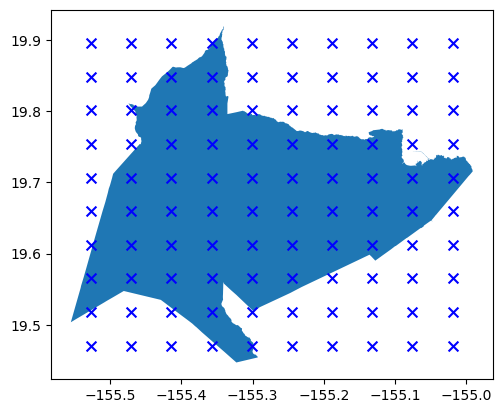

In [8]:
import geopandas as gpd
import matplotlib.pyplot as plt
from shapely.geometry import Point

# Assuming total_bbox is defined somewhere
total_bbox = (min_lon, min_lat, max_lon, max_lat)

# Generate midpoints and quadrants
midpoints, quadrants = generate_quadrants(*total_bbox, 10,10)

# Calculate center points in all quadrants
center_points = calculate_center_points(quadrants)

# Create a GeoDataFrame for the center points
gdf_center_points = gpd.GeoDataFrame(geometry=center_points)

# Load the base GeoJSON file (replace 'your_geojson_file.geojson' with the actual file path)
base_map = gpd.read_file('../data/boundaries/hilo.geojson')

# Plot the base map
base_map.plot()

# Plot the center points on top of the base map
gdf_center_points.plot(ax=plt.gca(), marker='x', color='blue', markersize=50)

# Show the plot
plt.show()


In [9]:
coordinates_list[0:5]

[(-155.52719205, 19.47059455),
 (-155.52719205, 19.517775649999997),
 (-155.52719205, 19.56495675),
 (-155.52719205, 19.612137849999996),
 (-155.52719205, 19.65931895)]

In [20]:
def get_geojson_centerpoints(geojson_file, n_lon, n_lat):
    '''Load GeoJSON file into GeoDataFrame to get the bounds'''
    gdf = gpd.read_file(geojson_file)

    '''Get the total bounding box of all features in the GeoDataFrame;
    The total bounding box is the area that encompasses all of the given 
    geographical area in the geojson file'''
    geojson_bbox = gdf.total_bounds

    '''Initialize min_lon, min_lat, max_lon, max_lat using 
    the bounding box of the GeoDataFrame, this will be used to
    create a large box which we will make sub-divisions from'''
    min_lon, min_lat, max_lon, max_lat = geojson_bbox

    '''maxing the values so that we make sure to stay as close to the
    the given geographical area'''
    total_bbox = (max(min_lon, geojson_bbox[0]), max(min_lat, geojson_bbox[1]),
                  min(max_lon, geojson_bbox[2]), min(max_lat, geojson_bbox[3]))

    center_points = []

    '''creating quadrants using midpoints'''
    for i in range(n_lon):
        for j in range(n_lat):
            quad_min_lon = min_lon + i * (max_lon - min_lon) / n_lon
            quad_max_lon = min_lon + (i + 1) * (max_lon - min_lon) / n_lon
            quad_min_lat = min_lat + j * (max_lat - min_lat) / n_lat
            quad_max_lat = min_lat + (j + 1) * (max_lat - min_lat) / n_lat

            '''corrects the bounds to make sure they're not outside the
            range of total bounds'''
            quad_min_lon = max(min_lon, min(quad_min_lon, max_lon))
            quad_max_lon = min(max_lon, max(quad_max_lon, min_lon))
            quad_min_lat = max(min_lat, min(quad_min_lat, max_lat))
            quad_max_lat = min(max_lat, max(quad_max_lat, min_lat))

            '''calculates center point'''
            center_lon = (quad_min_lon + quad_max_lon) / 2
            center_lat = (quad_min_lat + quad_max_lat) / 2
            center_point = (center_lon, center_lat)  # Changed to tuple
            center_points.append(center_point)
    '''center points are in a list as tuples for each point format'''
    return center_points


In [21]:
filepath = '../data/boundaries/hilo.geojson'
center_points = get_geojson_centerpoints(filepath,3,3)

In [22]:
center_points

[(-155.46134316666667, 19.525639166666664),
 (-155.46134316666667, 19.6829095),
 (-155.46134316666667, 19.84017983333333),
 (-155.2732035, 19.525639166666664),
 (-155.2732035, 19.6829095),
 (-155.2732035, 19.84017983333333),
 (-155.08506383333332, 19.525639166666664),
 (-155.08506383333332, 19.6829095),
 (-155.08506383333332, 19.84017983333333)]

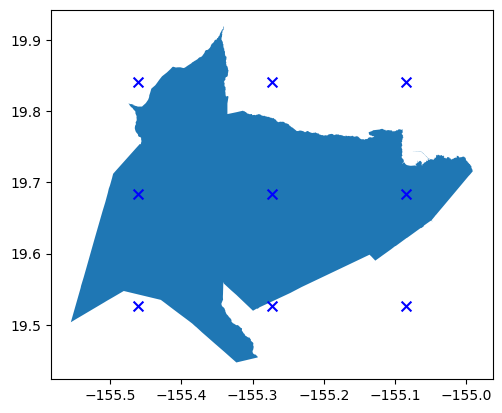

In [19]:
import matplotlib.pyplot as plt


gdf_center_points = gpd.GeoDataFrame(geometry=gpd.points_from_xy(*zip(*center_points)))

# Load the base GeoJSON file (replace 'your_geojson_file.geojson' with the actual file path)
base_map = gpd.read_file('../data/boundaries/hilo.geojson')

# Plot the base map
base_map.plot()

# Plot the center points on top of the base map
gdf_center_points.plot(ax=plt.gca(), marker='x', color='blue', markersize=50)

# Show the plot
plt.show()
plt.show()